In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [2]:
# We define a scalar valued function f(x), that takes a single scalar x, and returns scalr value y
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
print(f(3.0))

20.0


In [4]:
# We can plot this function to get a sense of it shape
xs=np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

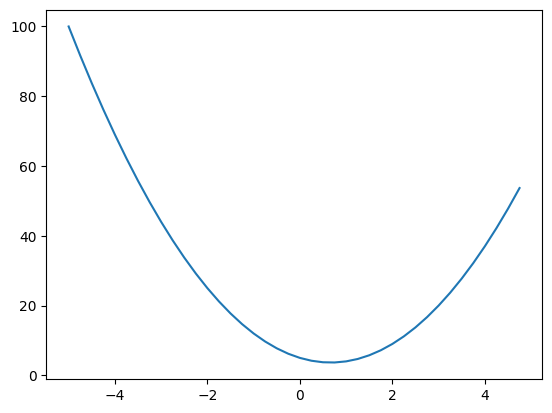

In [5]:
ys =f(xs)
ys
plt.plot(xs,ys)

In [ ]:
h=0.0000001
x=3.0
(f(x+h)-f(x))/h

14.000000305713911

In [ ]:
# Let take another function d
def d(a,b,c):
  return a*b+c

In [ ]:
a=2.0
b=-3.0
c=10.0
print(d(a,b,c))

4.0


In [ ]:
h=0.0001

#inputs, the values in which we are going to evaluate the derivate in respect to
a=2.0
b=-3.0
c=10.0

#a += h
d1=d(a,b,c)
a +=h
print('a',a)
d2=d(a,b,c)

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)
# d2 -d1 is how much the function increased when we bumped, the input by a small amount, and normalised by h




a 2.0001
d1 4.0
d2 3.999699999999999
slope -3.000000000010772


Let now experiment with b. WE look at the influence of b, on the output d

In [ ]:

h=0.0001

#inputs, the values in which we are going to evaluate the derivate in respect to
a=2.0
b=-3.0
c=10.0

#a += h
d1=d(a,b,c)
b +=h
print('a',a)
d2=d(a,b,c)

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)
# d2 -d1 is how much the function increased when we bumped, the input by a small amount, and normalised by h




a 2.0
d1 4.0
d2 4.0002
slope 2.0000000000042206


In [ ]:
# The influence of c
h=0.0001

#inputs, the values in which we are going to evaluate the derivate in respect to
a=2.0
b=-3.0
c=10.0

#a += h
d1=d(a,b,c)
c +=h
print('a',a)
d2=d(a,b,c)

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)
# d2 -d1 is how much the function increased when we bumped, the input by a small amount, and normalised by h


a 2.0
d1 4.0
d2 4.0001
slope 0.9999999999976694


In [ ]:
class Value:

  def __init__(self,data,_children=(),_op='',label=''):
    self.data= data
    self._prev = set(_children)
    self._op= _op
    self.label= label
    self.grad = 0.0

  # Repr for printing out nice expressions
  def __repr__(self):

    return f"Value(data={self.data})"
  # We define how to do addition
  def __add__(self,other):
    out= Value(self.data+other.data, (self,other),'+')
    return out

  def __mul__(self,other):
    out =Value(self.data*other.data, (self, other),"*")
    return out

In [ ]:
a=Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10.0,label='c')
e=a*b; e.label='e'
d=e+c; d.label='d'
f=Value(-2.0,label='f')
L=d*f; L.label='L'


Introducing children in Minigrad helps keep track of how a value was created, which is crucial for backpropagation (automatic differentiation).

## Why do we need children?

When we perform operations like addition (+) or multiplication (*), the resulting value depends on the inputs. To compute gradients during backpropagation, we need to know:

Where the value came from (its parents or operands).
How it was computed (operation type: addition, multiplication, etc.).
By storing children (references to the original values used in the operation), we can later traverse backward through the computation graph to calculate gradients.



In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s| data %.4f |grad %.4f }" % (n.label,n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

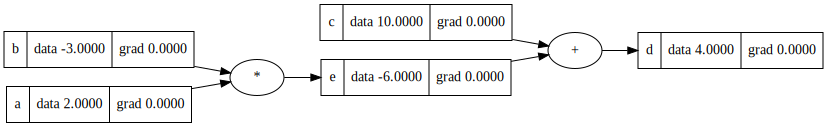

In [ ]:
draw_dot(d)

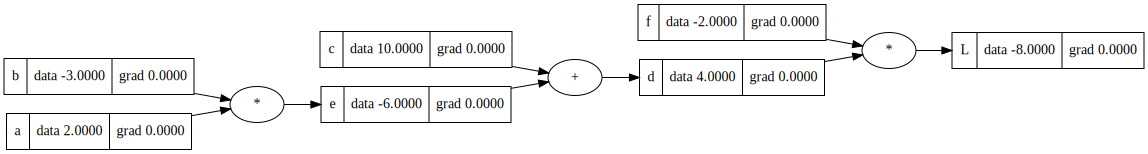

In [ ]:
draw_dot(L)

WE have built a mathematical expression, using plus and minus, which is scalar valued.We have multiple inputs, a,b,c,de,f that goes into a mathematical expression to produce a single output L(forward propagation).

Next, we need to do backpropagation.In this we are going to compute the derivate of all the inputs(weights) with respect to L(loss function).
We want to know how this weights are impacting the Loss function, so we are interested in the derivative of the output, with respect to some of it leaf nodes(Weight).

So now we create a variable grad, that maintains the derivative of L, with respect to L (Loss function).

WE start with grad=0, since we first assuming that every value does not impact the output, i.e the change in this variable does not change the loss function.

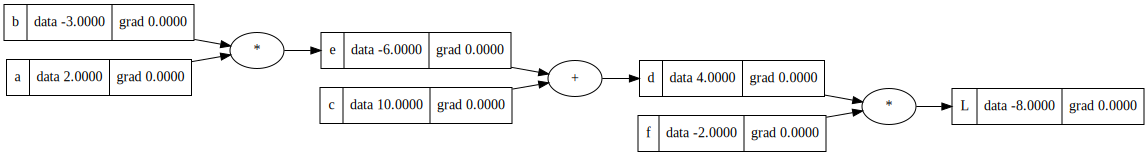

In [ ]:
draw_dot(L)

In [ ]:
def lol():

  h = 0.0001

  a = Value(2.0,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label='e'
  d = e+c; d.label='d'
  f = Value(-2.0,label='f')
  L = d*f; L.label='L'
  L1 = L.data

  a = Value(2.0 ,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label='e'
  d = e+c; d.label='d'
  f = Value(-2.0,label='f')
  L = d*f; L.label='L'
  L2 = L.data + h

  print ((L2-L1)/h)

In [ ]:
lol()

0.9999999999976694


In [ ]:
L.grad=1.0

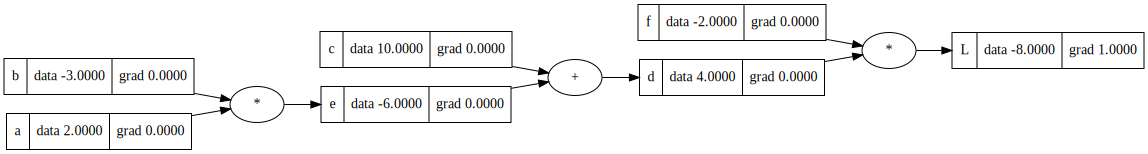

In [ ]:
draw_dot(L)

In [ ]:
#L = d * f

#dL/dd = f
# (f(x + h) - f(x))/h
#(f(d + h) - f(d))/h

# (f*d + f*h - f*d)/h
#f*h/h=f

#hence; dL/dd=f

#From this we have
d.grad = -2
f.grad = 4

In [ ]:
# We can confirm this, by calculating the derivative of of f and d
def lol():

  h = 0.001

  a = Value(2.0,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label='e'
  d = e+c; d.label='d'
  f = Value(-2.0,label='f')
  L = d*f; L.label='L'
  L1 = L.data

  a = Value(2.0 ,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label='e'
  d = e+c; d.label='d'
  f = Value(-2.0 +h,label='f')
  L = d*f; L.label='L'
  L2 = L.data

  print ((L2-L1)/h)

lol()

3.9999999999995595


In [ ]:
# We can confirm this, by calculating the derivative of of f and d
def lol():

  h = 0.001

  a = Value(2.0,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label='e'
  d = e+c; d.label='d'
  f = Value(-2.0,label='f')
  L = d*f; L.label='L'
  L1 = L.data

  a = Value(2.0 ,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label='e'
  d = e+c; d.label='d'
  d.data += h
  f = Value(-2.0 ,label='f')
  L = d*f; L.label='L'
  L2 = L.data

  print ((L2-L1)/h)

lol()

-2.000000000000668


We have done gradient check, which is when we are deriving this back propagation and getting the derivative with respect to all the intermediate results

Numerical gradient is estimating it using small step size.

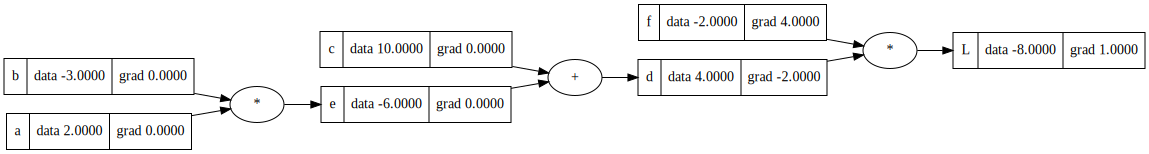

In [ ]:
draw_dot(L)

In [ ]:
#Now with want dl/dc
dd / dc = 1.0
dd / de= 1.0

d = c + e

WE WANT:
dL / dc

WE have:
DL / dd
dd / dc

Chain RUle:
dL/dc = dL/dd * dd/dc


In [ ]:
# We can confirm this, by calculating the derivative of of f and d
def lol():

  h = 0.001

  a = Value(2.0,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label='e'
  d = e+c; d.label='d'
  f = Value(-2.0,label='f')
  L = d*f; L.label='L'
  L1 = L.data

  a = Value(2.0 ,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label='e'
  e.data += h
  d = e+c; d.label='d'
  f = Value(-2.0 ,label='f')
  L = d*f; L.label='L'
  L2 = L.data

  print ((L2-L1)/h)

lol()

-2.000000000000668


In [ ]:
c.grad=-2
e.grad = -2

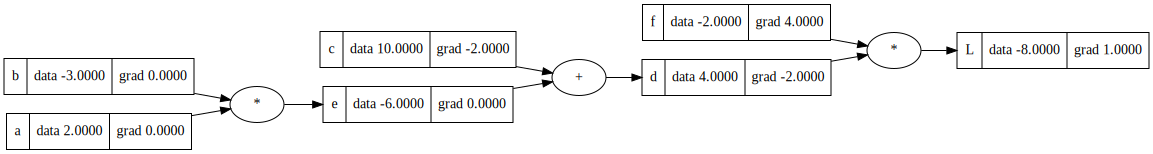

In [ ]:
draw_dot(L)

In [ ]:
def lol():

  h = 0.001

  a = Value(2.0,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label='e'
  d = e + c; d.label='d'
  f = Value(-2.0,label='f')
  L = d*f; L.label='L'
  L1 = L.data

  a = Value(2.0 ,label='a')
  b = Value(-3.0,label='b')
  b.data += h
  c = Value(10.0,label='c')
  e = a*b; e.label='e'
  e.data += h
  d = e+c; d.label='d'
  f = Value(-2.0 ,label='f')
  L = d*f; L.label='L'
  L2 = L.data

  print ((L2-L1)/h)

lol()

-6.000000000000227


In [ ]:
a.grad =-6
b.grad = -4

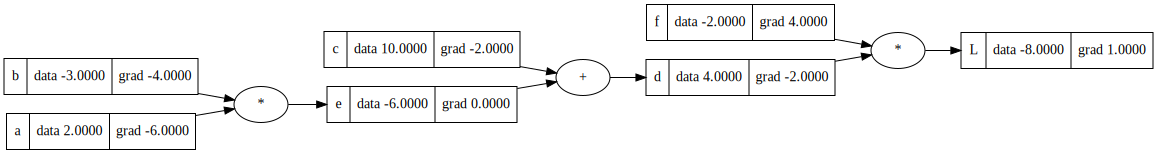

In [ ]:
draw_dot(L)

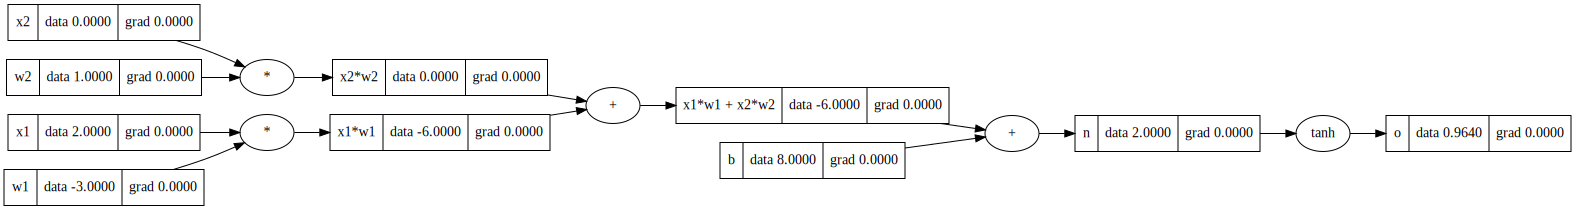

In [ ]:
class Value:

  def __init__(self,data,_children=(),_op='',label=''):
    self.data= data
    self._prev = set(_children)
    self._op= _op
    self.label= label
    self.grad = 0.0

  # Repr for printing out nice expressions
  def __repr__(self):

    return f"Value(data={self.data})"
  # We define how to do addition
  def __add__(self,other):
    out= Value(self.data+other.data, (self,other),'+')
    return out

  def __mul__(self,other):
    out =Value(self.data*other.data, (self, other),"*")
    return out

  def tanh(self):
    n = self.data
    t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(t, (self, ), 'tanh')
    return out



# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [ ]:
n.grad = 0.5
o.grad = 1.0

In [ ]:
x1w1.grad = 0.5
x2w2.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [ ]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

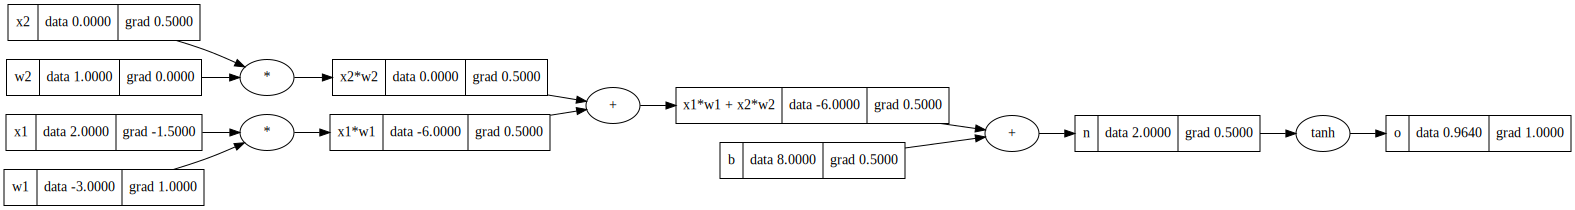

In [ ]:
draw_dot(o)

## Codifying the process

In [5]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [8]:
L.backward()

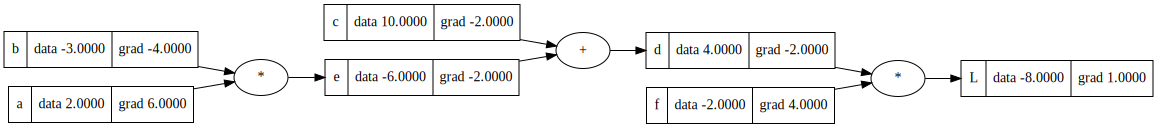

In [9]:
draw_dot(L)